# Apparent Horizon Finder

This notebook demonstrates the Apparent Horizon Finder for Kerr black holes with optional boosts.

**How to use:** Modify the parameters in each cell and re-run to explore different configurations.

**Reference:** Huq, Choptuik & Matzner (2000) - [arXiv:gr-qc/0002076](https://arxiv.org/abs/gr-qc/0002076)

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '..')

from ahfinder import ApparentHorizonFinder
from ahfinder.metrics import SchwarzschildMetric, KerrMetric
from ahfinder.metrics.schwarzschild_fast import SchwarzschildMetricFast
from ahfinder.metrics.boosted_kerr_fast import FastBoostedKerrMetric

%matplotlib inline
print("Imports successful!")

Imports successful!


## Helper Functions

In [5]:
def find_horizon(a=0.0, v=0.0, direction='x', N_s=21, tol=1e-8, max_iter=30, verbose=True):
    """
    Find apparent horizon for a Kerr black hole with optional boost.
    
    Parameters
    ----------
    a : float
        Spin parameter (0 to 0.99). a=0 is Schwarzschild, a>0 is Kerr.
    v : float
        Boost velocity (0 to ~0.8). v=0 means no boost.
    direction : str
        Boost direction: 'x', 'y', 'z', 'xy' (diagonal), or 'xyz' (diagonal)
    N_s : int
        Grid resolution. Higher = more accurate but slower. Try 17, 21, 25, 29.
    tol : float
        Newton solver tolerance.
    max_iter : int
        Maximum Newton iterations.
    verbose : bool
        Print convergence info.
    
    Returns
    -------
    x, y, z : arrays
        Horizon surface coordinates
    area : float
        Horizon area
    params : dict
        Parameters used
    """
    M = 1.0
    
    # Convert direction to velocity vector
    if direction == 'x':
        velocity = np.array([v, 0.0, 0.0])
    elif direction == 'y':
        velocity = np.array([0.0, v, 0.0])
    elif direction == 'z':
        velocity = np.array([0.0, 0.0, v])
    elif direction == 'xy':
        velocity = np.array([v/np.sqrt(2), v/np.sqrt(2), 0.0])
    elif direction == 'xyz':
        velocity = np.array([v/np.sqrt(3), v/np.sqrt(3), v/np.sqrt(3)])
    else:
        velocity = np.array([v, 0.0, 0.0])
    
    # Create metric
    if v < 0.01:  # No boost
        if a < 0.01:  # Schwarzschild
            metric = SchwarzschildMetricFast(M=M)
            initial_radius = 2.0 * M
        else:  # Kerr
            metric = KerrMetric(M=M, a=a)
            r_plus = M + np.sqrt(M**2 - a**2)
            initial_radius = np.sqrt(r_plus**2 + a**2)
    else:  # Boosted
        metric = FastBoostedKerrMetric(M=M, a=a, velocity=velocity)
        if a < 0.01:
            initial_radius = 2.0 * M
        else:
            r_plus = M + np.sqrt(M**2 - a**2)
            initial_radius = np.sqrt(r_plus**2 + a**2)
    
    # Find horizon
    finder = ApparentHorizonFinder(
        metric, N_s=N_s,
        use_vectorized_jacobian=True
    )
    
    rho = finder.find(
        initial_radius=initial_radius,
        tol=tol,
        max_iter=max_iter,
        verbose=verbose
    )
    
    x, y, z = finder.horizon_coordinates(rho)
    area = finder.horizon_area(rho)
    
    return x, y, z, area, {'a': a, 'v': v, 'direction': direction}


def plot_horizon(x, y, z, area, params, elev=20, azim=45, cmap='viridis'):
    """
    Plot the horizon surface.
    
    Parameters
    ----------
    x, y, z : arrays
        Horizon coordinates from find_horizon()
    area : float
        Horizon area
    params : dict
        Parameters dict from find_horizon()
    elev : float
        Viewing elevation angle (-90 to 90)
    azim : float
        Viewing azimuth angle (0 to 360)
    cmap : str
        Colormap: 'viridis', 'plasma', 'coolwarm', 'copper', etc.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Color by radius
    r = np.sqrt(x**2 + y**2 + z**2)
    colors = plt.colormaps[cmap]((r - r.min()) / (r.max() - r.min() + 1e-10))
    
    ax.plot_surface(x, y, z, facecolors=colors, alpha=0.9, shade=True)
    
    # Equal aspect ratio
    max_range = max(x.max() - x.min(), y.max() - y.min(), z.max() - z.min()) / 2
    mid_x = (x.max() + x.min()) / 2
    mid_y = (y.max() + y.min()) / 2
    mid_z = (z.max() + z.min()) / 2
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Labels
    title = f"Apparent Horizon: a/M={params['a']:.2f}"
    if params['v'] > 0.01:
        title += f", v/c={params['v']:.2f} ({params['direction']})"
    title += f"\nArea = {area:.4f}"
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)
    
    plt.tight_layout()
    plt.show()

print("Helper functions defined!")

Helper functions defined!


## Example 1: Schwarzschild Black Hole

Spherical horizon at r = 2M.

Newton iteration for apparent horizon:
  N_s = 21, tol = 1e-08, mode = Vectorized Sparse Jacobian
--------------------------------------------------
  Iter   0: ||F|| = 4.660754e-03  Vectorized Sparse Jacobian: 9297 nonzeros (5.8%), 9749 evals
, ||δρ|| = 4.120386e-03
  Iter   1: ||F|| = 4.136789e-06  Vectorized Sparse Jacobian: 9298 nonzeros (5.8%), 9749 evals
, ||δρ|| = 7.443680e-06
  Iter   2: ||F|| = 7.131456e-09
--------------------------------------------------
Converged in 3 iterations


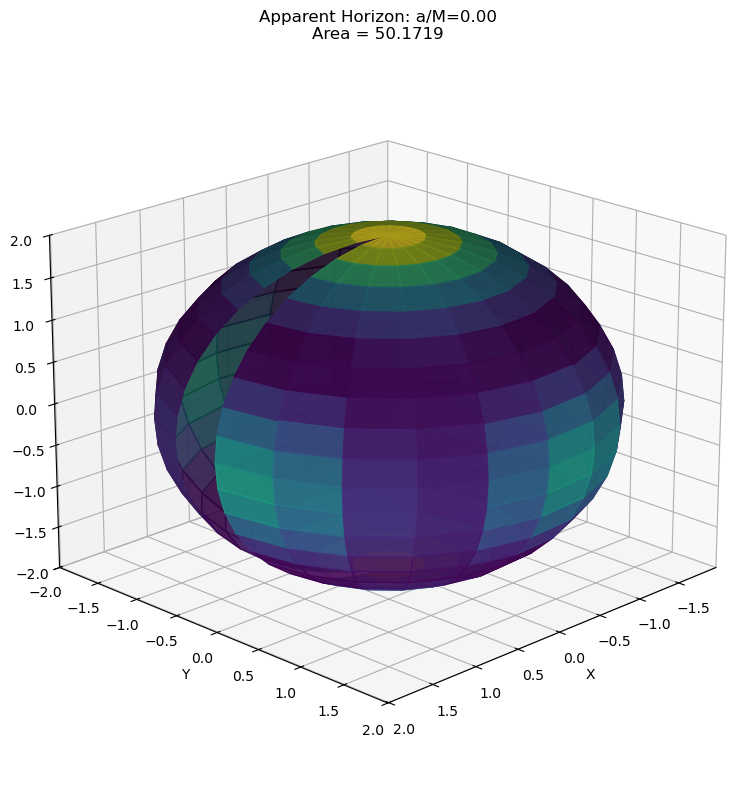

Expected area (4*pi*r_H^2): 50.2655


In [8]:
# === PARAMETERS (modify these) ===
a = 0.0           # Spin (0 = Schwarzschild)
v = 0.0           # Boost velocity
direction = 'x'   # Boost direction
N_s = 21          # Resolution
tol = 1e-8        # Solver tolerance

# View angles
elev = 20         # Elevation (-90 to 90)
azim = 45         # Azimuth (0 to 360)
cmap = 'viridis'  # Colormap
# =================================

x, y, z, area, params = find_horizon(a=a, v=v, direction=direction, N_s=N_s, tol=tol)
plot_horizon(x, y, z, area, params, elev=elev, azim=azim, cmap=cmap)

print(f"Expected area (4*pi*r_H^2): {4*np.pi*4:.4f}")

## Example 2: Kerr Black Hole

Oblate horizon due to spin. Higher spin = more flattening along spin axis (z).

Newton iteration for apparent horizon:
  N_s = 21, tol = 1e-08, mode = Vectorized Sparse Jacobian
--------------------------------------------------
  Iter   0: ||F|| = 2.746684e+00  Vectorized Sparse Jacobian: 9389 nonzeros (5.8%), 9773 evals
, ||δρ|| = 1.959845e+00
  Iter   1: ||F|| = 4.091729e-01  Vectorized Sparse Jacobian: 9783 nonzeros (6.1%), 9809 evals
, ||δρ|| = 2.464682e-01
  Iter   2: ||F|| = 7.493638e-03  Vectorized Sparse Jacobian: 9779 nonzeros (6.1%), 9797 evals
, ||δρ|| = 3.460079e-03
  Iter   3: ||F|| = 6.436003e-06  Vectorized Sparse Jacobian: 9666 nonzeros (6.0%), 9797 evals
, ||δρ|| = 5.971292e-06
  Iter   4: ||F|| = 7.909885e-09
--------------------------------------------------
Converged in 5 iterations


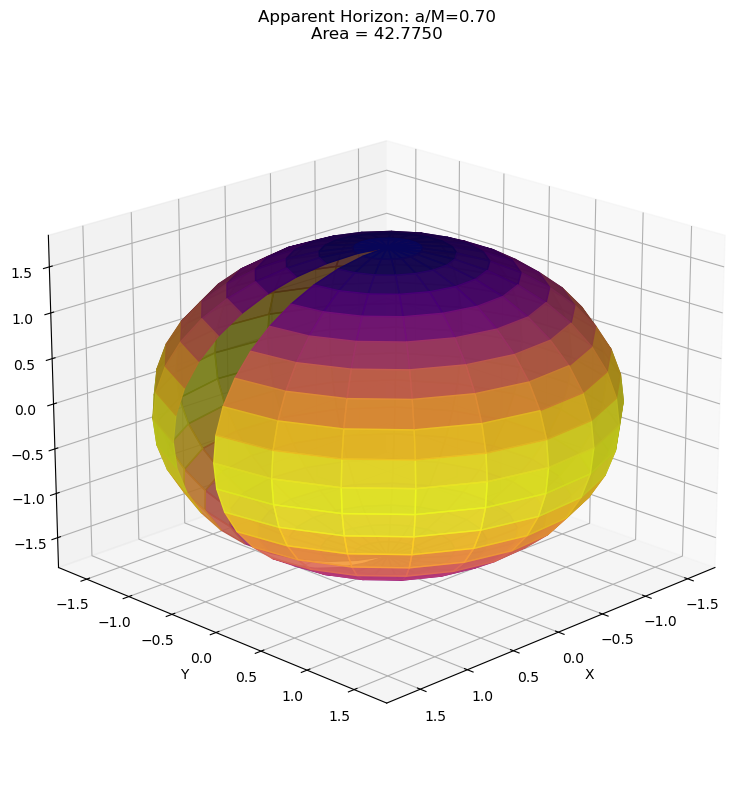

Expected area: 43.0811


In [11]:
# === PARAMETERS (modify these) ===
a = 0.7           # Spin (try 0.3, 0.5, 0.7, 0.9, 0.99)
v = 0.0           # Boost velocity
direction = 'x'   # Boost direction
N_s = 21          # Resolution
tol = 1e-8        # Solver tolerance

# View angles
elev = 20
azim = 45
cmap = 'plasma'
# =================================

x, y, z, area, params = find_horizon(a=a, v=v, direction=direction, N_s=N_s, tol=tol)
plot_horizon(x, y, z, area, params, elev=elev, azim=azim, cmap=cmap)

# Expected area for Kerr
r_plus = 1 + np.sqrt(1 - a**2)
expected_area = 4 * np.pi * (r_plus**2 + a**2)
print(f"Expected area: {expected_area:.4f}")

## Example 3: Boosted Schwarzschild

Lorentz contracted in boost direction, but **area is invariant**!

Newton iteration for apparent horizon:
  N_s = 21, tol = 1e-08, mode = Vectorized Sparse Jacobian
--------------------------------------------------
  Iter   0: ||F|| = 2.284113e+00  Vectorized Sparse Jacobian: 9297 nonzeros (5.8%), 9749 evals
, ||δρ|| = 2.074221e+00
  Iter   1: ||F|| = 3.641790e-01  Vectorized Sparse Jacobian: 9717 nonzeros (6.0%), 9749 evals
, ||δρ|| = 2.662667e-01
  Iter   2: ||F|| = 7.714895e-03  Vectorized Sparse Jacobian: 9620 nonzeros (6.0%), 9749 evals
, ||δρ|| = 4.517133e-03
  Iter   3: ||F|| = 4.311047e-06  Vectorized Sparse Jacobian: 9415 nonzeros (5.9%), 9749 evals
, ||δρ|| = 7.926684e-06
  Iter   4: ||F|| = 8.665450e-09
--------------------------------------------------
Converged in 5 iterations


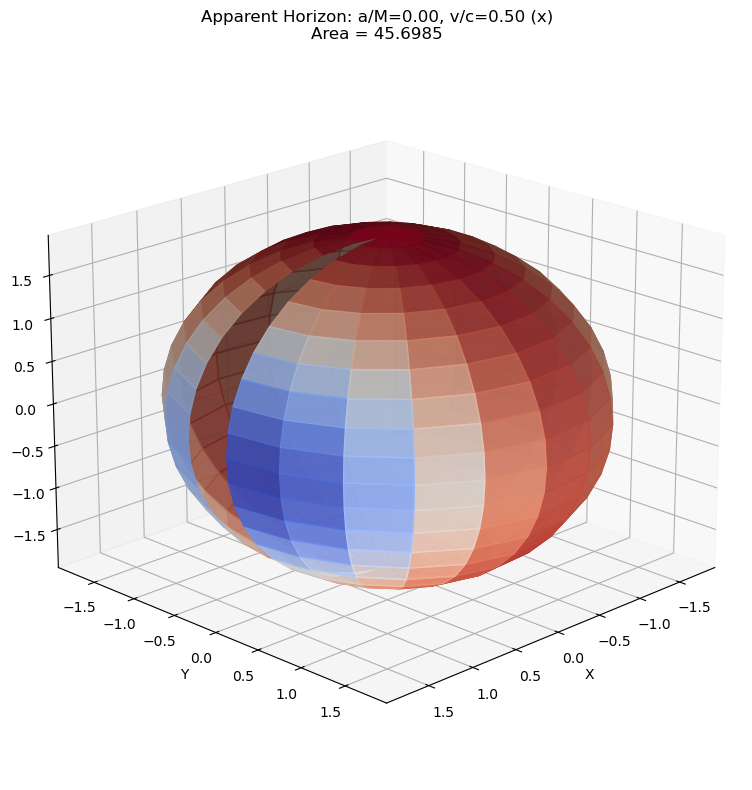

Expected area (unboosted): 50.2655
Area ratio: 0.909143 (should be ~1.0 - area is Lorentz invariant!)


In [14]:
# === PARAMETERS (modify these) ===
a = 0.0           # Spin
v = 0.5           # Boost velocity (try 0.3, 0.5, 0.6)
direction = 'x'   # Boost direction ('x', 'y', 'z', 'xy', 'xyz')
N_s = 21          # Resolution
tol = 1e-8        # Solver tolerance

# View angles
elev = 20
azim = 45
cmap = 'coolwarm'
# =================================

x, y, z, area, params = find_horizon(a=a, v=v, direction=direction, N_s=N_s, tol=tol)
plot_horizon(x, y, z, area, params, elev=elev, azim=azim, cmap=cmap)

expected_area = 4 * np.pi * 4  # 4*pi*r_H^2 for Schwarzschild
print(f"Expected area (unboosted): {expected_area:.4f}")
print(f"Area ratio: {area/expected_area:.6f} (should be ~1.0 - area is Lorentz invariant!)")

## Example 4: Boosted Kerr

Both spin and boost - the most general case.

Newton iteration for apparent horizon:
  N_s = 21, tol = 1e-08, mode = Vectorized Sparse Jacobian
--------------------------------------------------
  Iter   0: ||F|| = 1.281291e+00  Vectorized Sparse Jacobian: 9389 nonzeros (5.8%), 9773 evals
, ||δρ|| = 1.810142e+00
  Iter   1: ||F|| = 1.242174e-01  Vectorized Sparse Jacobian: 9773 nonzeros (6.1%), 9773 evals
, ||δρ|| = 1.482537e-01
  Iter   2: ||F|| = 9.553151e-04  Vectorized Sparse Jacobian: 9773 nonzeros (6.1%), 9773 evals
, ||δρ|| = 7.839913e-04
  Iter   3: ||F|| = 9.022266e-07  Vectorized Sparse Jacobian: 9561 nonzeros (5.9%), 9773 evals
, ||δρ|| = 1.595190e-06
  Iter   4: ||F|| = 2.461625e-09
--------------------------------------------------
Converged in 5 iterations


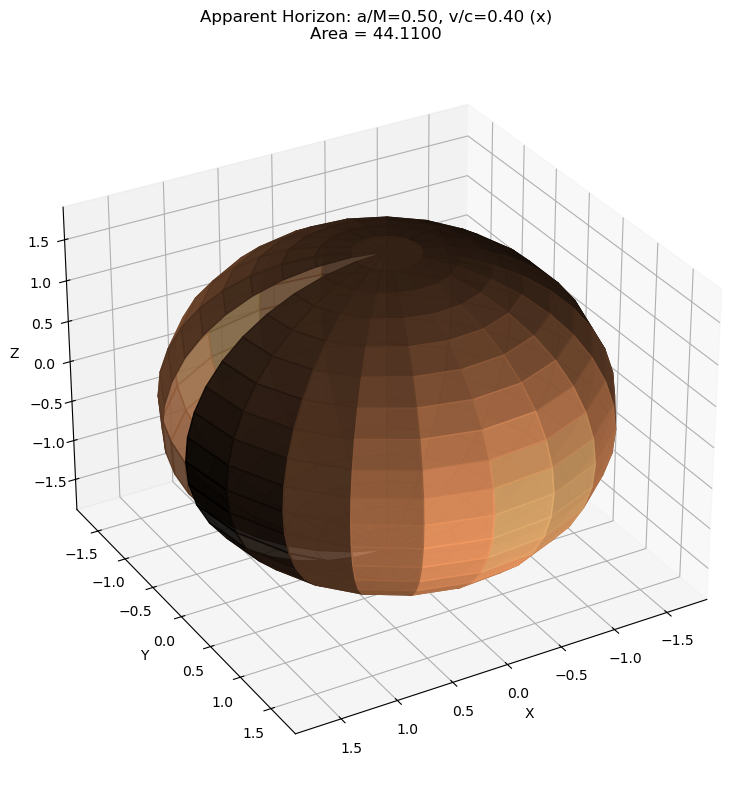

Expected area (unboosted Kerr): 46.8983
Area ratio: 0.940544


In [17]:
# === PARAMETERS (modify these) ===
a = 0.5           # Spin
v = 0.4           # Boost velocity
direction = 'x'   # Boost direction
N_s = 21          # Resolution
tol = 1e-8        # Solver tolerance

# View angles
elev = 30
azim = 60
cmap = 'copper'
# =================================

x, y, z, area, params = find_horizon(a=a, v=v, direction=direction, N_s=N_s, tol=tol)
plot_horizon(x, y, z, area, params, elev=elev, azim=azim, cmap=cmap)

# Expected area for Kerr (unboosted)
r_plus = 1 + np.sqrt(1 - a**2)
expected_area = 4 * np.pi * (r_plus**2 + a**2)
print(f"Expected area (unboosted Kerr): {expected_area:.4f}")
print(f"Area ratio: {area/expected_area:.6f}")

## Example 5: Multiple Viewing Angles

See the horizon from front, side, and top.

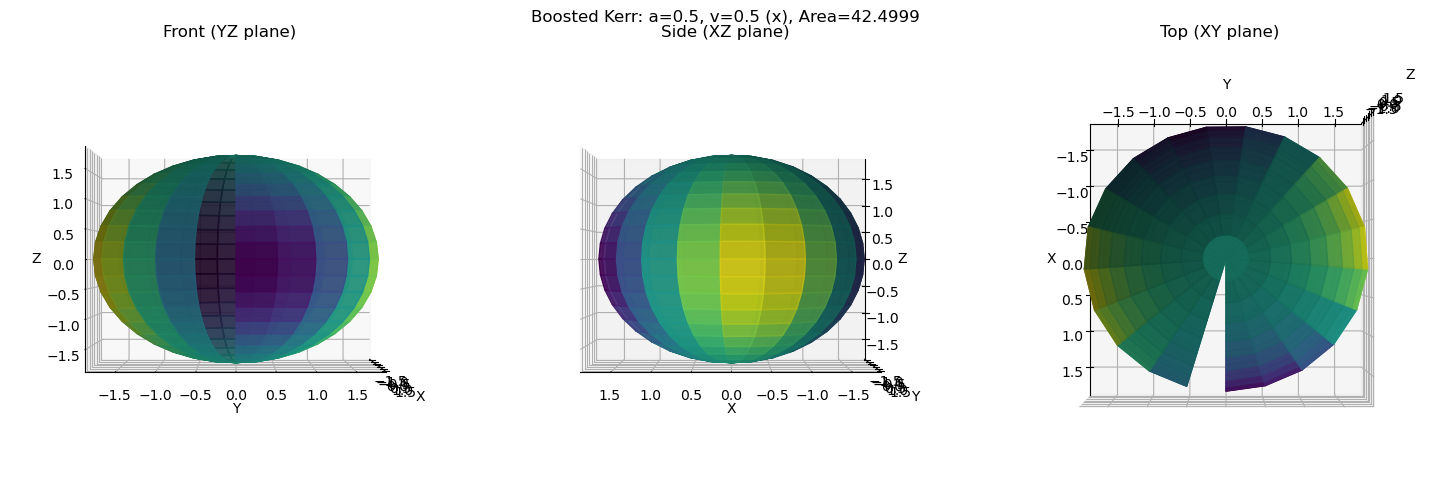

In [20]:
# === PARAMETERS (modify these) ===
a = 0.5           # Spin
v = 0.5           # Boost velocity
direction = 'x'   # Boost direction
N_s = 21          # Resolution
tol = 1e-8        # Solver tolerance
# =================================

x, y, z, area, params = find_horizon(a=a, v=v, direction=direction, N_s=N_s, tol=tol, verbose=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

views = [
    (0, 0, 'Front (YZ plane)'),
    (0, 90, 'Side (XZ plane)'),
    (90, 0, 'Top (XY plane)')
]

for ax, (elev, azim, title) in zip(axes, views):
    r = np.sqrt(x**2 + y**2 + z**2)
    colors = plt.colormaps['viridis']((r - r.min()) / (r.max() - r.min() + 1e-10))
    ax.plot_surface(x, y, z, facecolors=colors, alpha=0.9)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Equal aspect
    max_range = max(x.max() - x.min(), y.max() - y.min(), z.max() - z.min()) / 2
    mid_x, mid_y, mid_z = (x.max() + x.min()) / 2, (y.max() + y.min()) / 2, (z.max() + z.min()) / 2
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.suptitle(f'Boosted Kerr: a={a}, v={v} ({direction}), Area={area:.4f}')
plt.tight_layout()
plt.show()

## Example 6: Spin Comparison

Compare different spin values side by side.

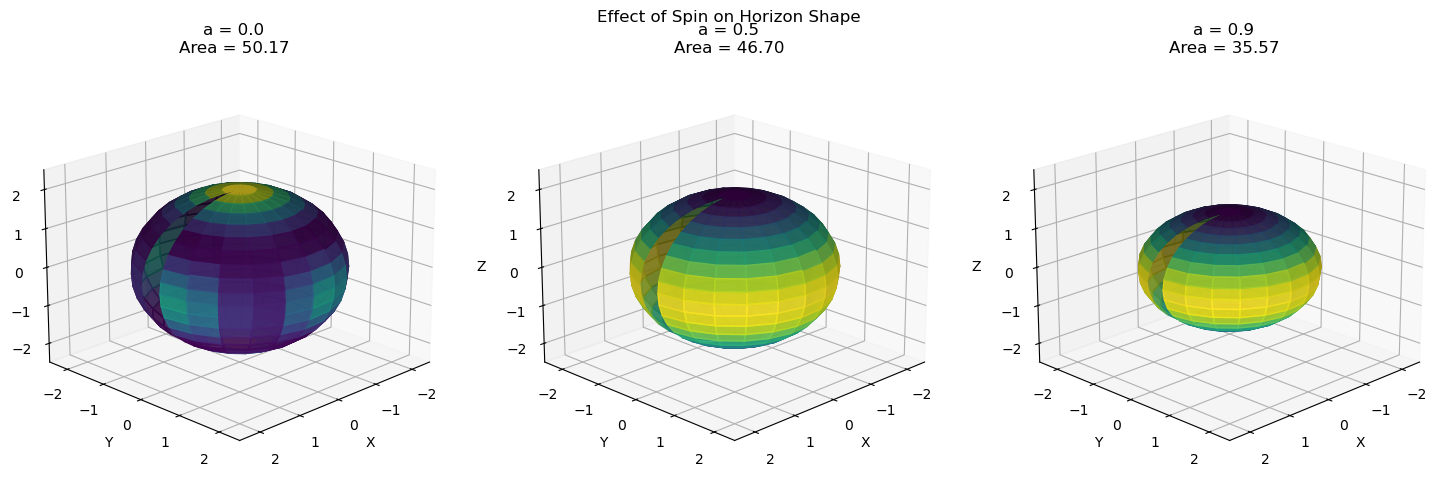

In [23]:
# === PARAMETERS (modify these) ===
spins = [0.0, 0.5, 0.9]  # Spin values to compare
N_s = 21
tol = 1e-8
# =================================

fig, axes = plt.subplots(1, len(spins), figsize=(5*len(spins), 5), subplot_kw={'projection': '3d'})

for ax, a in zip(axes, spins):
    x, y, z, area, params = find_horizon(a=a, v=0, N_s=N_s, tol=tol, verbose=False)
    
    r = np.sqrt(x**2 + y**2 + z**2)
    colors = plt.colormaps['viridis']((r - r.min()) / (r.max() - r.min() + 1e-10))
    ax.plot_surface(x, y, z, facecolors=colors, alpha=0.9)
    ax.set_title(f'a = {a}\nArea = {area:.2f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20, azim=45)
    
    # Equal aspect with same scale for all
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_zlim(-2.5, 2.5)

plt.suptitle('Effect of Spin on Horizon Shape')
plt.tight_layout()
plt.show()

## About the Physics

### Apparent Horizons

An apparent horizon is a surface where outgoing light rays have zero expansion:

$$\Theta = D_i s^i + K_{ij} s^i s^j - K = 0$$

where:
- $s^i$ is the outward unit normal to the surface
- $K_{ij}$ is the extrinsic curvature of the spatial slice
- $D_i$ is the spatial covariant derivative

### Key Observations

1. **Schwarzschild** (a=0): Perfect sphere at $r = 2M$

2. **Kerr** (a>0): Oblate spheroid, flattened along the spin axis

3. **Boosted**: Lorentz contracted in boost direction, but **area is invariant**!
   - This is a deep result: the horizon area equals the irreducible mass squared
   - $A = 16\pi M_{irr}^2$ is a Lorentz scalar

### Algorithm

This implementation follows [Huq, Choptuik & Matzner (2000)](https://arxiv.org/abs/gr-qc/0002076):
- Surface parameterized as $r = \rho(\theta, \phi)$ on spherical grid
- Newton iteration with vectorized sparse Jacobian
- **112x speedup** over baseline (66s → 0.6s at N_s=25)